In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
nTurn = 128
errIndex = 0
betx = 1.90650539547772
alfx = 1.4082261070868625
nCore_y = 4
nCore_z = 4
n_particles = 100000
nx = 0
NL_t = 0.4
NL_c = 0.01

# 1. Preparation

In [3]:
beam, lattice = impact.readInputFile('test_IOTA.in')
beam.current = 0.0

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
beam.nCore_y=nCore_y
beam.nCore_z=nCore_z

In [5]:
print(beam.distribution.emitx/NL_c**2)

0.001460964633548756


### 1.2. generate particles

##### 1.2.1. generate pData

In [6]:
beamtmp = copy(beam)
beamtmp.n_particles=n_particles
beamtmp.distribution.distribution_type = 'IOTA_Waterbag'
beamtmp.distribution.NL_t = NL_t
beamtmp.distribution.NL_c = NL_c


impact.writeInputFile(beamtmp,[]);
impact.run(beamtmp)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles
input error <- beam.multi_charge.current[0] not qual to beam.current
  ... enforcing  beam.multi_charge.current[0] to beam.current


0

In [7]:
ke = beamtmp.kinetic_energy
mass = beamtmp.mass
freq = beamtmp.frequency
pData = impact.readParticleData(-111110,ke,mass,freq)
print(pData.shape)

(100000, 9)


##### 1.2.2. check pData

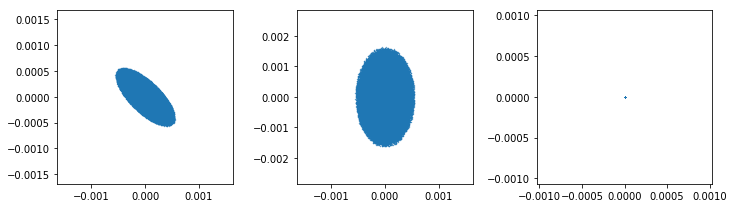

In [8]:
plt.figure(figsize=[10.3,3])
plt.subplot(1,3,1)
plt.scatter(pData[:,0],pData[:,1],s=0.1)
plt.subplot(1,3,2)
plt.scatter(pData[:,0],pData[:,2],s=0.1)
plt.subplot(1,3,3)
plt.scatter(pData[:,4],pData[:,5],s=0.1)
plt.tight_layout()

##### 1.2.3. generate testP

In [9]:
testP = 0.0
sig = 0.01
k=0
q_m = beamtmp.multi_charge.q_m[0]
pTest = []
for x in np.linspace(-0.01,0.01,nx):
    for y in np.linspace(-0.01,0.01,nx):
        if x**2+y**2<=sig**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])            
            
pTest = np.array(pTest)
nptTest = len(pTest)
print('initial npt=',nptTest)

initial npt= 0


##### 1.2.4. combine pData, pTest  and Check

In [10]:
pData[:,8] = pData[:,8] + nptTest
if nptTest>0:
    pData = np.concatenate((pTest,pData),axis=0)
print(pData.shape)
impact.writeParticleData(pData, ke, mass, freq)

(100000, 9)


In [11]:
beam.n_particles = n_particles + nptTest
impact.writeInputFile(beam,[]);
impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles
input error <- beam.multi_charge.current[0] not qual to beam.current
  ... enforcing  beam.multi_charge.current[0] to beam.current


0

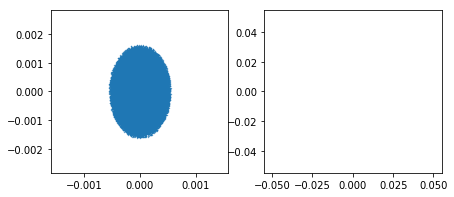

In [12]:
pData = impact.readParticleData(-111110, ke, mass, freq)
plt.figure(figsize=[7,3])
plt.subplot(1,2,1)
plt.scatter(pData[nptTest:,0],pData[nptTest:,2],s=0.1);
plt.subplot(1,2,2)
plt.scatter(pData[:nptTest,0],pData[:nptTest,2],s=0.1);

### 1.3 adjust lattice

In [13]:
lattice[0].turns = 2*nTurn
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        lattice[i].n_sckick = int(lattice[i].length*30)
        if lattice[i].type in ['nonlinear_insert','dipole']:
            lattice[i].n_sckick = int(lattice[i].length*60)
            lattice[i].n_map = 5
        else:
            lattice[i].n_map = 2
        
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]

# 2. Run

In [14]:
print('===========================')
print('=========== run ===========')
print('===========================')

=========== run ===========


In [15]:
impact.writeInputFile(beam,lattice) 
#impact.run(beam)

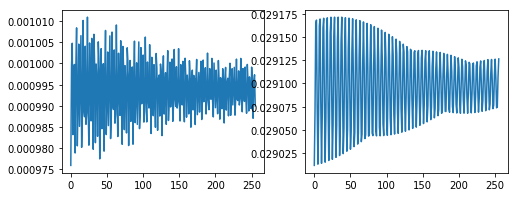

In [17]:
Inv = np.loadtxt('fort.81')
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(Inv[:,1]) 
plt.subplot(1,2,2)
plt.plot(Inv[:,2])

In [18]:
cat test.in

!================= Beam & Control Parameters ================= 
8 4 
6 100000 1 0 1 
64 64 1025 7 0.05 0.05 0.1 
23 0 0 1 
100000 
0.0 
1.0657889726792521e-09 
0.0007108541000000002 7.481793000000001e-05 0.8153394 1.0 1.0 0.0 0.0 
0.0007108541000000002 7.481793000000001e-05 0.8153394 1.0 1.0 0.0 0.0 
2.2092772151898727 1e-14 0.0 1.0 1.0 0.0 0.0 
0.0 2500000.0 938272045.0 1.0 30000000.0 0.0 
!========================== Lattice ========================== 
0.0 0 0 -16 0.0 256 / 
0.0 0 95 -8 64 / 
1.8 108 5 6 0.4 0.01 0.3034496449165134 10.0 / 
0.0 0 98 -8 64 / 
0.045 1 2 0 1.0 / 
0.1075 3 2 0 1.0 / 
0.21 6 2 1 -8.218039338095238 -1 0.15 0.0 0.0 0.0 0.0 0.0 / 
0.13 3 2 0 1.0 / 
0.21 6 2 1 14.27877214761905 -1 0.15 0.0 0.0 0.0 0.0 0.0 / 
0.13 3 2 0 1.0 / 
0.21 6 2 1 -11.935380171428573 -1 0.15 0.0 0.0 0.0 0.0 0.0 / 
0.0725 2 2 0 1.0 / 
0.1 3 2 0 1.0 / 
0.2 6 2 0 1.0 / 
0.7330382858 43 5 4 1.047197551 0.0 350 0.058 0.0 0.0 0.0 0.0 0.5 / 
0.2 6 2 0 1.0 / 
0.1 3 2 0 1.0 / 
0.055 1 2 0 1.0 / 
0